# Advance Machine Learning Project

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Data Pre-Processing

In [2]:
# open function opens a file for reading. 'r' meaning open file in a reading mode.
# open function returns a file object.
# read function pulls the entire content of the file as a string and saves it in a variable named names.

names = open('babygirls.txt', 'r').read()

In [3]:
# lower function makes all names as lower case. 
# We do this because we want to use 26 alphabets instead of 52(treating lower and upper case as same.)
names = names.lower()

In [4]:
# Names is a long string having all names in a single string separated by \n
# To extract unique letters, we use the set function of python.
# list converts the set into a list. It becomes easy to index at a later stage.
characters = list(set(names))

In [5]:
total_characters = len(names)
unique_characters = len(characters)

In [6]:
print('There are %d total characters and %d unique characters in the dataset we use.' % (total_characters, unique_characters))

There are 7756 total characters and 27 unique characters in the dataset we use.


In [7]:
# Converting characters to indexes between 0-26 including \n. This \n acts as end of a name.
# We will use python dictionary i.e. a hash table.
# Enumerate function accesses elements from a list i.e. characters here alomg with the indexes.
# sorted functed sorts the list.
character_to_indexes = {ch:i for i,ch in enumerate(sorted(characters)) }
index_to_characters = {i:ch for i,ch in enumerate(sorted(characters))}
print(character_to_indexes)
print(index_to_characters)

{'\n': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '\n', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


# Building Language Model

# The Problem of Exploding Gradients.
One of the problems in Recurrent Neural Networks is that the gradients can become too large(Exploding Gradients). This problem is solved using gradient clipping. We restrict the range of values that gradients can take. This is done using the clip function of numpy.

In [8]:
def gradient_clip(gradients, max_value):
    """Function Parameters: gradients: Python dictionary containing all gradient vectors/matrices.
    max_value: The range of value to which we want to restrict the gradients."""
    
    # Accessing the gradients from the dictionary.
    dWaa, dWax, dWya, db, dby = gradients['dWaa'], gradients['dWax'], gradients['dWya'], gradients['db'], gradients['dby']
    
    for gradient in [dWax, dWaa, dWya, db, dby]:      # Looping over the list of gradient vectors.
        # Clip function clips the values of gradient vector b/w -max_value to max_value element wise.
        # If an element of vector is greater than max_value, it will become equal to max_value and same for less than 
        # max_value.
        # If value lies between -max_value to max_value, it remains the same.
        np.clip(gradient,-max_value,max_value,out=gradient) 
        
    gradients = {"dWaa": dWaa, "dWax": dWax, "dWya": dWya, "db": db, "dby": dby}
    
    return gradients 

In [9]:
# Softmax Function
def softmax(x):
    # x-np.max(x) is done because np.exp(large number) can become infinity.
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)
    

# Sampling Characters from a trained Network.
Assuming that we have an already trained network, we write a function to sample characters from the trained RNN Model.

In [10]:
def sample(parameters , character_to_indexes):
    """Function Parameters: parameters: a dictionary containing model parmeters
        character_to_indexes: dictionary mapping characters to their indexes.
        
        Return: Function returns a list containing indices generated."""
    
    # Retrieving parameters from the dictionary. 
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    
    vocab_size = by.shape[0]   # Size of Output vector y which is same at all time steps.
    
    n_a = Waa.shape[0]         # Size of activation vector.
    
    # Initializing vector x for first character input. It will be zero.
    # We could create a vector of random values as well.
    x = np.zeros((vocab_size,1))
    
    # Initializing a_prev as zeros.
    a_prev = np.zeros((n_a, 1))
    
    # Initializing an empty list of indices, which will contain list of indices from which we generate names.
    indices = []
    
    # Flag to detect a newline character.
    next_character = -1
    
    # Looping over time steps 't' to forward propagate and predict output y i.e. index of character generated.
    # We sample from a probability distribution randomly at each time step.
    # Also, we don't want to have names larger than say(20) characters. So, we use counter to stop the loop.
    # Counter will also prevent from entering into an infinite loop.
    
    counter = 0
    
    newline_character = character_to_indexes['\n']
    
    # Looping over the time steps 't' 
    while( next_character != newline_character and counter != 20):
       
        # Forward Propagating 'x'
        # Calculating the activation.
        a = np.tanh(np.dot(Wax,x) + np.dot(Waa,a_prev) + b)
        # Calculating the output vector.
        z = np.dot(Wya,a) + by
        # Taking softmax of the output vector.
        y = softmax(z)
        
        
        # np.random.choice chooses an index from [0,1,...,26] using probability distribution given by y.
        # y is vector having probability of choosing an index.
        # We could also choose argmax of y but we want to sample randomly.
        next_character = np.random.choice(list(range(vocab_size)), p = y.ravel())
        
        # Appending the index to the indices list.
        indices.append(next_character)
        
        # Overwriting the input character as the one corresponding to the sampled index.
        # To be input for next timer step 't'.
        x = np.zeros((vocab_size,1))
        x[next_character] = 1
        
        # Updating a_prev to be 'a' for next time step.
        
        a_prev = a
        
        # Increasing the counter.
        counter += 1
        
    
    if (counter == 50):
        indices.append(character_to_indexes['\n'])
    
    return indices

In [11]:
np.random.seed(2)
_, n_a = 20, 100
vocab_size = len(characters)
Wax, Waa, Wya = np.random.randn(n_a, vocab_size), np.random.randn(n_a, n_a), np.random.randn(vocab_size, n_a)
b, by = np.random.randn(n_a, 1), np.random.randn(vocab_size, 1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b, "by": by}


indices = sample(parameters, character_to_indexes)
print("Sampling:")
print("list of sampled indices:", indices)
print("list of sampled characters:", [index_to_characters[i] for i in indices])

Sampling:
list of sampled indices: [12, 23, 24, 14, 7, 2, 10, 23, 25, 12, 3, 24, 15, 24, 3, 20, 3, 17, 4, 0]
list of sampled characters: ['l', 'w', 'x', 'n', 'g', 'b', 'j', 'w', 'y', 'l', 'c', 'x', 'o', 'x', 'c', 't', 'c', 'q', 'd', '\n']


# Building Language Model Using RNN:
It is a 4 Steps Process:<br>
1) Forward Propagate <br>
2) Calculate Loss<br>
3) Find Gradients<br>
4) Update Parameters<br>

We are using Stochastic Gradient Descent i.e. using 1 example at a time to update the parameters.

In [12]:
# This Function runs 1 time step forward propagation through a RNN Cell.
def rnn_cell_forward(parameters, a_prev, x):
    
    """Function Parameters: parameters: A python dictionary containing network parameters
        a_prev: activation of previous time step
        x: Input of current time step."""
    # Retrieving Python Dictionary.
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    # Computing Hidden State Activation.
    a_next = np.tanh(np.dot(Wax, x) + np.dot(Waa, a_prev) + b) 
    # Current time step output.
    p_t = softmax(np.dot(Wya, a_next) + by)  
    
    return a_next, p_t

In [13]:
def rnn_step_backward(dy, gradients, parameters, x , a , a_prev):
    """Function Parameters: dy: Derivative of cost w.r.t output y
       Gradients: Python dictionary containing gradients
       Parameters: A python dictionary containing network parameters
       x: The input numpy array.
       a: Activation of the current state
       a_prev: Activation of the previous state."""
    
    gradients['dWya'] += np.dot(dy, a.T)
    gradients['dby'] += dy
    # backprop into h
    da = np.dot(parameters['Wya'].T, dy) + gradients['da_next'] 
    # backprop through tanh nonlinearity
    daraw = (1 - a * a) * da 
    gradients['db'] += daraw
    gradients['dWax'] += np.dot(daraw, x.T)
    gradients['dWaa'] += np.dot(daraw, a_prev.T)
    gradients['da_next'] = np.dot(parameters['Waa'].T, daraw)
    
    return gradients

In [14]:
def update_parameters(parameters, gradients, lr):

    parameters['Wax'] += -lr * gradients['dWax']
    parameters['Waa'] += -lr * gradients['dWaa']
    parameters['Wya'] += -lr * gradients['dWya']
    parameters['b']  += -lr * gradients['db']
    parameters['by']  += -lr * gradients['dby']
    return parameters

In [15]:
def rnn_forward(X, Y, a0, parameters, vocab_size = 27):
    
    # Initialize x, a and y_hat as empty dictionaries
    x, a, y_hat = {}, {}, {}
    
    a[-1] = np.copy(a0)
    
    # initialize your loss to 0
    loss = 0
    
    for t in range(len(X)):
        
        # Set x[t] to be the one-hot vector representation of the t'th character in X.
        # if X[t] == None, we just have x[t]=0. This is used to set the input for the first timestep to the zero vector. 
        x[t] = np.zeros((vocab_size,1)) 
        if (X[t] != None):
            # Making one-hot vector
            x[t][X[t]] = 1
            
        # Run one step forward of the RNN
        a[t], y_hat[t] = rnn_cell_forward(parameters, a[t-1], x[t])
        
        # Update the loss by substracting the cross-entropy term of this time-step from it.
        loss -= np.log(y_hat[t][Y[t],0])
        
        
        
    cache = (y_hat, a, x)
        
    return loss, cache


In [16]:
def rnn_backward(X, Y, parameters, cache):
    '''Function Parameters: X: The training data example 
       Y: The training data example.
       parameters: The dictionary of parameters'''
    # Initialize gradients as an empty dictionary
    gradients = {}
    
    # Retrieve from cache and parameters
    (y_hat, a, x) = cache
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    
    # each one should be initialized to zeros of the same dimension as its corresponding parameter
    gradients['dWax'], gradients['dWaa'], gradients['dWya'] = np.zeros_like(Wax), np.zeros_like(Waa), np.zeros_like(Wya)
    gradients['db'], gradients['dby'] = np.zeros_like(b), np.zeros_like(by)
    gradients['da_next'] = np.zeros_like(a[0])
    
    
    # Backpropagate through time
    for t in reversed(range(len(X))):
        dy = np.copy(y_hat[t])
        dy[Y[t]] -= 1
        gradients = rnn_step_backward(dy, gradients, parameters, x[t], a[t], a[t-1])
    
    
    return gradients, a


In [17]:
def smooth(loss, cur_loss):
    return loss * 0.999 + cur_loss * 0.001

def print_sample(sample_ix, ix_to_char):
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    txt = txt[0].upper() + txt[1:]  # capitalize first character 
    print ('%s' % (txt, ), end='')

def get_initial_loss(vocab_size, seq_length):
    return -np.log(1.0/vocab_size)*seq_length


In [18]:
def initialize_parameters(n_a, n_x, n_y):
    """
    Initialize parameters with small random values
    
    Returns:
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        b --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    """
    np.random.seed(1)
    Wax = np.random.randn(n_a, n_x)*0.01 # input to hidden
    Waa = np.random.randn(n_a, n_a)*0.01 # hidden to hidden
    Wya = np.random.randn(n_y, n_a)*0.01 # hidden to output
    b = np.zeros((n_a, 1)) # hidden bias
    by = np.zeros((n_y, 1)) # output bias
    
    parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b,"by": by}
    
    return parameters

In [19]:
# GRADED FUNCTION: optimize

def optimize(X, Y, a_prev, parameters, learning_rate = 0.01):
    """
    Execute one step of the optimization to train the model.
    
    Arguments:
    X -- list of integers, where each integer is a number that maps to a character in the vocabulary.
    Y -- list of integers, exactly the same as X but shifted one index to the left.
    a_prev -- previous hidden state.
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        b --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    learning_rate -- learning rate for the model.
    
    Returns:
    loss -- value of the loss function (cross-entropy)
    gradients -- python dictionary containing:
                        dWax -- Gradients of input-to-hidden weights, of shape (n_a, n_x)
                        dWaa -- Gradients of hidden-to-hidden weights, of shape (n_a, n_a)
                        dWya -- Gradients of hidden-to-output weights, of shape (n_y, n_a)
                        db -- Gradients of bias vector, of shape (n_a, 1)
                        dby -- Gradients of output bias vector, of shape (n_y, 1)
    a[len(X)-1] -- the last hidden state, of shape (n_a, 1)
    """
    
    
    # Forward propagate through time (≈1 line)
    loss, cache = rnn_forward(X, Y, a_prev, parameters)
    
    
    # Backpropagate through time (≈1 line)
    gradients, a = rnn_backward(X, Y, parameters, cache)
    
    # Clip your gradients between -5 (min) and 5 (max) (≈1 line)
    gradients = gradient_clip(gradients, 5)
    
    # Update parameters (≈1 line)
    parameters = update_parameters(parameters, gradients, learning_rate)
    
    
    return loss, gradients, a[len(X)-1]

In [20]:
# GRADED FUNCTION: model

def model(data, index_to_characters, character_to_indexes, num_iterations = 100 , n_a = 50, baby_names = 100, vocab_size = 27):
    """
    Trains the model and generates baby names. 
    
    Arguments:
    data -- text corpus
    ix_to_char -- dictionary that maps the index to a character
    char_to_ix -- dictionary that maps a character to an index
    num_iterations -- number of iterations to train the model for
    n_a -- number of units of the RNN cell
    baby_names -- number of baby names you want to sample at each iteration. 
    vocab_size -- number of unique characters found in the text, size of the vocabulary
    
    Returns:
    parameters -- learned parameters
    """
    
    # Retrieve n_x and n_y from vocab_size
    n_x, n_y = vocab_size, vocab_size
    
    # Initialize parameters
    parameters = initialize_parameters(n_a, n_x, n_y)
    
    
    # Initialize loss (this is required because we want to smooth our loss, don't worry about it)
    loss = get_initial_loss(vocab_size, baby_names)
    
    # Build list of all baby names (training examples).
    with open("babygirls.txt") as f:
        examples = f.readlines()
    examples = [x.lower().strip() for x in examples] # examples is list of all training examples.
    
    # Shuffle list of all baby names
   
    np.random.shuffle(examples)
    
    # Initialize the hidden state of RNN
    a_prev = np.zeros((n_a, 1))
    
    # Loss list.
    
    # Optimization loop
    loss_list = []
    loss_list2 = []
    for i in range(num_iterations):
        total_loss = 0
        for j in range(len(examples)):
         
            index = j 
       
            X = [None] + [character_to_indexes[ch] for ch in examples[index]] 
            Y = X[1:] + [character_to_indexes["\n"]]
        
            # Perform one optimization step: Forward-prop -> Backward-prop -> Clip -> Update parameters
            # Choose a learning rate of 0.01
            curr_loss, gradients, a_prev = optimize(X, Y, a_prev, parameters, learning_rate = 0.01)
        
        
            # Use a latency trick to keep the loss smooth. It happens here to accelerate the training.
            loss = smooth(loss, curr_loss)
            #print(loss)
            total_loss += loss
            loss_list2.append(loss)
            
            # Every 2000 Iteration, generate "n" characters.
        if i % 10 == 0:
            
            print('Iteration: %d, Loss: %f' % (i, loss) + '\n')
            
            # The number of baby names to print
            seed = 0
            for name in range(baby_names):
                
                # Sample indices and print them
                sampled_indices = sample(parameters, character_to_indexes)
                print_sample(sampled_indices, index_to_characters)
            
      
            print('\n')
        
        loss_list.append(total_loss)
        
    return parameters , loss_list , loss_list2

In [21]:
parameters , loss_list , loss_list2  = model(names, index_to_characters, character_to_indexes)

Iteration: 0, Loss: 122.491408

Lxejeleyniha
Ea
Aeaenaya
Mafitresrannle
E
Argatana
Gci
Fdanaa
RryxhbmlradoahokahyaAdosnealicaldeelagvaTahialqaigoi
Dnims
A
Jmdssaiy

Gse
Mba
S
Iia
Sarazgia
A
Hllee
Jge
Altkidailyna
Yoanre
Ma
Arraniea

Alsa
Laie
PaalrarerteafamihhaaBierleleantallla
Nhmamasaey
Ea
Nkya
Ina

Lifmama
Tmj
Ado
Iasjlnjre
Lyerle
Seqja
Oa
Sta
Da
Iiyflsa
Da
Ebnxiyya
Sja
Janla
Cka
Ypa
Nye
Rfjillcr
Lcia
Nchnvainionnnseha
CnanktmlainaibealvaePateciarsrdalzoneea
M
Leen
A
Mahyplrao
Ta
Alsahsyyele
Oanraie
Orin
Aliokila
Aslibalatpa
Ia
Yerdmanjmewyenure
Ye
Ayiam
Rira
Nrjnlsyajana
Yhr

Rt
Miaei
Jot
Renlslayr
ZadsnlhdsrveanmiiqorA
Piahljrdlieelana
Gha
M
Mihnmar

Inia
Mwa
Zrn

I
Alera
Fmyenrlmoke
Qazi
Ga
Ndrn
Nanadsla



Iteration: 10, Loss: 14.916606

Waelaclah
Caebea
Rkhelya
Mirlandana
Syevvabetta
Faimen
Rvajaca
Courenn
Missa
Marey
Raree
Aireton
Svirna
Phbetel
Laliscia
Elania
Rlenjemtarena
Voriet
Miten
Jaii
Miliaggathy
Leta
Kiyla
Peie
Marmeszsysyn
Myckazdadrigba
Mila
Lery
Areriva
Miki
Sijab

Text(0,0.5,'Cost of an Example')

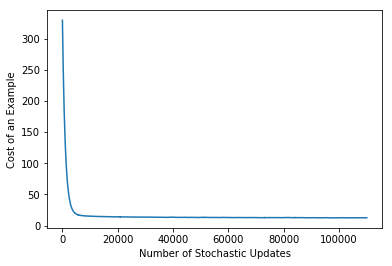

In [22]:
plt.plot(loss_list2)
plt.xlabel("Number of Stochastic Updates")
plt.ylabel("Cost of an Example")

Text(0,0.5,'Total cost of all examples in an epoch')

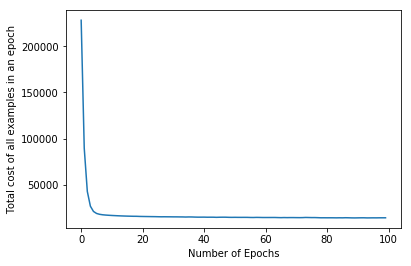

In [23]:
plt.plot(loss_list)
plt.xlabel("Number of Epochs")
plt.ylabel("Total cost of all examples in an epoch")

In [24]:
print(parameters)

{'Wax': array([[  1.62434536e-02,   4.91484254e-01,  -1.82446832e+00, ...,
          8.66793980e-02,  -1.93698655e+00,   6.16819446e-02],
       [ -9.35769434e-03,  -2.97614798e+00,  -1.82043177e+00, ...,
         -6.96521344e-01,   1.07062823e+00,   9.72353259e-01],
       [ -2.08894233e-03,  -5.29676308e-01,  -1.16259239e+00, ...,
          5.69273581e-01,  -1.26397701e+00,   5.69825697e-01],
       ..., 
       [  2.19477494e-03,  -4.19920638e+00,  -6.95892914e-01, ...,
          5.01857073e-01,   1.51578058e+00,   6.19303547e-01],
       [  6.03035910e-03,  -9.04365779e-02,   2.42451456e+00, ...,
         -9.55558294e-01,  -3.07039300e+00,  -9.87766723e-01],
       [  8.73005837e-03,   4.84590273e-01,   1.84956588e+00, ...,
         -2.87467500e-01,  -3.26461822e+00,  -2.89448892e-01]]), 'Waa': array([[-0.20705129, -0.29739349, -1.06949436, ..., -0.80124283,
        -0.52911181,  0.12166674],
       [-0.14933432,  0.15788951,  0.28942445, ...,  0.57998869,
         0.26887917,  0.1

In [25]:
def sample_new(parameters, character_to_indexes, nick):
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    
    vocab_size = by.shape[0]   # Size of Output vector y which is same at all time steps.
    
    n_a = Waa.shape[0]         # Size of activation vector.
    
    # Initializing vector x for first character input. It will be zero.
    # We could create a vector of random values as well.
    if (len(nick) == 0):
        x = np.zeros((vocab_size,1))
    
    # Initializing a_prev as zeros.
        a_prev = np.zeros((n_a, 1))
    
    # Initializing an empty list of indices, which will contain list of indices from which we generate names.
    
        indices = []
    
    # Flag to detect a newline character.
        next_character = -1
    
    # Looping over time steps 't' to forward propagate and predict output y i.e. index of character generated.
    # We sample from a probability distribution randomly at each time step.
    # Also, we don't want to have names larger than say(20) characters. So, we use counter to stop the loop.
    # Counter will also prevent from entering into an infinite loop.
    
        counter = 0
    
        newline_character = character_to_indexes['\n']
    
    # Looping over the time steps 't' 
        while( next_character != newline_character and counter != 20):
       
        # Forward Propagating 'x'
        # Calculating the activation.
            a = np.tanh(np.dot(Wax,x) + np.dot(Waa,a_prev) + b)
        # Calculating the output vector.
            z = np.dot(Wya,a) + by
        # Taking softmax of the output vector.
            y = softmax(z)
        
        
        # np.random.choice chooses an index from [0,1,...,26] using probability distribution given by y.
        # y is vector having probability of choosing an index.
        # We could also choose argmax of y but we want to sample randomly.
            next_character = np.random.choice(list(range(vocab_size)), p = y.ravel())
        
        # Appending the index to the indices list.
            indices.append(next_character)
        
        # Overwriting the input character as the one corresponding to the sampled index.
        # To be input for next timer step 't'.
            x = np.zeros((vocab_size,1))
            x[next_character] = 1
        
        # Updating a_prev to be 'a' for next time step.
        
            a_prev = a
        
        # Increasing the counter.
            counter += 1
        
    
        if (counter == 20):
            indices.append(character_to_indexes['\n'])
    
    else:
        x = np.zeros((vocab_size,1))
    
    # Initializing a_prev as zeros.
        a_prev = np.zeros((n_a, 1))
    
    # Initializing an empty list of indices, which will contain list of indices from which we generate names.
    
        indices = []
    
    # Flag to detect a newline character.
        next_character = -1
    
    # Looping over time steps 't' to forward propagate and predict output y i.e. index of character generated.
    # We sample from a probability distribution randomly at each time step.
    # Also, we don't want to have names larger than say(20) characters. So, we use counter to stop the loop.
    # Counter will also prevent from entering into an infinite loop.
    
        counter = 0
    
        newline_character = character_to_indexes['\n']
        
        for i in range(len(nick)):
            # Forward Propagating 'x'
        # Calculating the activation.
            a = np.tanh(np.dot(Wax,x) + np.dot(Waa,a_prev) + b)
        # Calculating the output vector.
            z = np.dot(Wya,a) + by
        # Taking softmax of the output vector.
            y = softmax(z)
            
        # np.random.choice chooses an index from [0,1,...,26] using probability distribution given by y.
        # y is vector having probability of choosing an index.
        # We could also choose argmax of y but we want to sample randomly.
            next_character = character_to_indexes[nick[i]]
        
        # Appending the index to the indices list.
            indices.append(next_character)
        
        # Overwriting the input character as the one corresponding to the sampled index.
        # To be input for next timer step 't'.
            x = np.zeros((vocab_size,1))
            x[next_character] = 1
        
        # Updating a_prev to be 'a' for next time step.
        
            a_prev = a
        
        # Increasing the counter.
            counter += 1
        
    
        while(next_character != newline_character and counter != 20):
       
        # Forward Propagating 'x'
        # Calculating the activation.
            a = np.tanh(np.dot(Wax,x) + np.dot(Waa,a_prev) + b)
        # Calculating the output vector.
            z = np.dot(Wya,a) + by
        # Taking softmax of the output vector.
            y = softmax(z)
        
        
        # np.random.choice chooses an index from [0,1,...,26] using probability distribution given by y.
        # y is vector having probability of choosing an index.
        # We could also choose argmax of y but we want to sample randomly.
            next_character = np.random.choice(list(range(vocab_size)), p = y.ravel())
        
        # Appending the index to the indices list.
            indices.append(next_character)
        
        # Overwriting the input character as the one corresponding to the sampled index.
        # To be input for next timer step 't'.
            x = np.zeros((vocab_size,1))
            x[next_character] = 1
        
        # Updating a_prev to be 'a' for next time step.
        
            a_prev = a
        
        # Increasing the counter.
            counter += 1
        
    
        if (counter == 50):
            indices.append(character_to_indexes['\n'])
        
            
    return indices
    

In [34]:
nick = input("Enter starting/nick name: ")

Enter starting/nick name: claire


In [35]:
#generates_names = set()
for i in range(20):
    check = sample_new(parameters ,character_to_indexes, nick)
    name = print_sample(check, index_to_characters)
    #generated_names.add(name)

Clairey
Claire
Claire
Clairea
Clairer
Claire
Claire
Clairen
Claire
Clairen
Clairencely
Claire
Claire
Clairee
Clairen
Clairen
Claireth
Clairene
Claire
Clairevi


# Training Using LSTM:

In [61]:
with open("babygirls.txt") as f:
        examples = f.readlines()
examples = [x.lower().strip() for x in examples]      # examples is list of all training examples.
examples[4]    

'isabella'

In [8]:
# importing important libraries:
from keras.models import load_model, Model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector,SimpleRNN
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras.optimizers import Adam 

Using TensorFlow backend.


In [9]:
# Keras uses one-hot encoding for sequences :
# Converting names to indices :
with open("babygirls.txt") as f:
    examples = f.readlines()
examples = [x.lower().strip() for x in examples]

In [10]:
len(examples)

1100

In [122]:
model = Sequential()

In [123]:
model.add(LSTM(27, return_sequences=True , input_shape=(None,27), activation = 'tanh'))

In [124]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [125]:
print(model.summary())
model.input_shape


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, None, 27)          5940      
Total params: 5,940
Trainable params: 5,940
Non-trainable params: 0
_________________________________________________________________
None


(None, None, 27)

In [126]:
a = model.get_weights()

In [128]:
a 

[array([[ 0.0126594 ,  0.20984386, -0.10330032, ..., -0.10230265,
          0.04305981, -0.17863609],
        [ 0.1659434 ,  0.07140179, -0.12459808, ..., -0.02105293,
         -0.11039771, -0.0960347 ],
        [ 0.03899634,  0.09243278, -0.0483529 , ..., -0.03800078,
          0.17989351,  0.02427579],
        ..., 
        [-0.13841745, -0.03599533,  0.09876876, ..., -0.19090757,
          0.06479667,  0.03887002],
        [ 0.1752079 , -0.15396276, -0.15619208, ..., -0.05465056,
          0.14368974, -0.16434957],
        [ 0.06567059, -0.08544584, -0.17480831, ..., -0.20616415,
          0.1740175 , -0.19782576]], dtype=float32),
 array([[-0.08276286,  0.09480623,  0.00747002, ..., -0.0846485 ,
          0.06224215,  0.1561757 ],
        [ 0.01877646,  0.02737487, -0.14958543, ...,  0.17500615,
         -0.03214522, -0.0259013 ],
        [ 0.01590555,  0.19464493,  0.06376348, ...,  0.03016294,
         -0.15988843, -0.06097747],
        ..., 
        [ 0.01887506, -0.01427871,  0

In [129]:
# Training the model
for k in range(1):
    for j in range(len(examples)):
         
            X = [0] + [character_to_indexes[ch] for ch in examples[j]] 
            Y = X[1:] + [character_to_indexes["\n"]]
        
            X_train = np.zeros((len(X),27))
            Y_train = np.zeros((len(Y),27))
        
            for i in range(len(X)):
                X_train[i][X[i]] = 1
                Y_train[i][Y[i]] = 1
        
        
            X_train = X_train.reshape(1,len(X),27)
            Y_train = Y_train.reshape(1,len(Y),27)
            history = model.fit(X_train,Y_train)     

Epoch 1/1
1/1 [==============================] - 0s 486ms/step - loss: 16.1181 - acc: 0.2000
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 5.2230 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 11.8317 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 12.3603 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 9.0934 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 9.4893 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 6.3602 - acc: 0.1250
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 8.6631 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 8ms/step - loss: 10.9793 - acc: 0.1000
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 5.7437 - acc: 0.1429
Epoch 1/1
1/1 [==============================] - 0s 9ms/step - loss: 1

Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 5.8053 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 8ms/step - loss: 7.1636 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 9.4146 - acc: 0.1667
Epoch 1/1
1/1 [==============================] - 0s 9ms/step - loss: 8.0951 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 9.3542 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 10ms/step - loss: 8.9545 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 10ms/step - loss: 11.5129 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 9ms/step - loss: 7.2732 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 10ms/step - loss: 3.3214 - acc: 0.1667
Epoch 1/1
1/1 [==============================] - 0s 9ms/step - loss: 8.5323 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 12ms/step - 

Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 6.1525 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 6.1022 - acc: 0.1250
Epoch 1/1
1/1 [==============================] - 0s 9ms/step - loss: 11.4337 - acc: 0.1000
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 9.4573 - acc: 0.1250
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 12.6229 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 8ms/step - loss: 7.1251 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 8.2916 - acc: 0.1667
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 10.5608 - acc: 0.1250
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 8.2437 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 10.1279 - acc: 0.1250
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 10.5329 - a

Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 9.6709 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 6.4552 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 3.2236 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 13.0033 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 5.9607 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 10ms/step - loss: 7.1736 - acc: 0.1111
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 7.0483 - acc: 0.1429
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 9.7318 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 10.8745 - acc: 0.1111
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 10.2723 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 8ms/step - loss:

Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 6.6385 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 8ms/step - loss: 8.3552 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 14.1033 - acc: 0.1250
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 12.8945 - acc: 0.2000
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 1.1921e-07 - acc: 0.2500
Epoch 1/1
1/1 [==============================] - 0s 8ms/step - loss: 7.1989 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 4.1932 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 5.5207 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 9.6919 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 8.1931 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - los

Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 8.0590 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 4.6918 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 13.5045 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 10ms/step - loss: 8.4602 - acc: 0.1250
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 10.7454 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 6.4472 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 6.3756 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 8.0590 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 6.0796 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 5.6945 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 7ms/step 

Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 9.4433 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 8.2337 - acc: 0.1250
Epoch 1/1
1/1 [==============================] - 0s 8ms/step - loss: 14.2181 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 9.2103 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 9.2103 - acc: 0.1429
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 9.2298 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 8.0590 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 11.1381 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 4.1656 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 10.2947 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 10ms/step - l

Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 11.6057 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 8.3425 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 6.9687 - acc: 0.1429
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 9.2103 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 10.0738 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 8.1533 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 7.0839 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 9.2576 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 10ms/step - loss: 7.4049 - acc: 0.1111
Epoch 1/1
1/1 [==============================] - 0s 8ms/step - loss: 10.7454 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - l

Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 5.3727 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 8ms/step - loss: 8.9643 - acc: 0.2222
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 4.6052 - acc: 0.2857
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 6.1230 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 11.0407 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 10.7454 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 8.2477 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 12.8945 - acc: 0.2000
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 10.7887 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 10.1216 - acc: 0.2500
Epoch 1/1
1/1 [==============================] - 0s 10ms/step - loss: 7

Epoch 1/1
1/1 [==============================] - 0s 8ms/step - loss: 11.6188 - acc: 0.2000
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 5.8556 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 6.9471 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 8.3504 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 8.0590 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 10ms/step - loss: 9.6736 - acc: 0.1000
Epoch 1/1
1/1 [==============================] - 0s 8ms/step - loss: 3.6052 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 9.2103 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 8.0590 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 6.3337 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - los

Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 9.2103 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 8ms/step - loss: 10.7454 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 13.8155 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 8ms/step - loss: 6.1497 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 4.7166 - acc: 0.1429
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 4.0295 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 5.4077 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 9ms/step - loss: 10.2845 - acc: 0.1250
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 13.4317 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 9ms/step - loss: 4.6354 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 9ms/step - l

Epoch 1/1
1/1 [==============================] - 0s 13ms/step - loss: 4.8510 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 4.0481 - acc: 0.1250
Epoch 1/1
1/1 [==============================] - 0s 8ms/step - loss: 11.7223 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 8.4042 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 7.3250 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 11.5129 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 8ms/step - loss: 10.0738 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 11ms/step - loss: 16.1181 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 8ms/step - loss: 11.5129 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 8ms/step - loss: 7.3117 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 6ms/s

Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 8.0590 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 9.2103 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 10ms/step - loss: 8.1372 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 6.5421 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 9.3614 - acc: 0.1429
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 8.1446 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 8.0590 - acc: 0.1667
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 3.8013 - acc: 0.1111
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 6.0443 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 6.4472 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 9ms/step - loss: 4.

# LSTM Cell
